Ok, so this was Bernardo's idea. We run PSA on MNIST and then classify with different datasets and look at classification accuracies.

In [1]:
import numpy as np

from FlagRep import FlagRep

import itertools
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os
from skimage import color
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d
import torch

from PSA_utils import *

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
def load_mnist_data(digits, sample_size=100, dset='train', shuffle = False, data_path = './data/MNIST/'):
    '''
    Shannon Stiverson's dataloader

    Inputs:
        digits- list or int for digits from MNIST to be samples
        sample_size - number of samples of that digit
        dset - 'train' or 'test' for sampling from the training or the test datasets
    Outputs:
        out_datamat - a numpy array of dimensions (784 x sample_size)
        datamat_labels - a list of labels of the sampled points
    '''

    if type(digits) == int:
        digits = [digits]

    if type(sample_size) == int:
        sample_size = [sample_size]*len(digits)

    if len(sample_size) != len(digits):
        print('Incorrect number of sample sizes given.')
        return [], []

    return_data = []
    return_labels = []

    for i in range(len(digits)):
        digit = digits[i]
        size = sample_size[i]
        digit_data = np.loadtxt(data_path+'%s%i.csv' % (dset, digit), delimiter=',')
        if digit_data.shape[1] < size:
            print('Sample number for digit %i reduced to %i' % (digit, digit_data.shape[1]))
            return_data.append(digit_data)
            return_labels.append([digit]*digit_data.shape[1])
        else:
            if shuffle:
                idx = np.random.choice(np.arange(digit_data.shape[1]), size)
            else:
                idx = np.arange(size)
            return_data.append(digit_data[idx, :])
            return_labels.append([digit]*size)

    datamat = return_data[0]
    datamat_labels = return_labels[0]

    if len(digits) > 1:
        for i in range(1, len(digits)):
            datamat = np.vstack((datamat, return_data[i]))
            datamat_labels = np.hstack((datamat_labels, return_labels[i]))

    out_datamat = datamat.T
    
    return out_datamat, datamat_labels

In [3]:
data_path= '/Users/natemankovich/Documents/GradProjects/CVPR2022/data/MNIST/'

1
Accuracy: 49.17%
5
Accuracy: 81.67%
------------
1
Accuracy: 48.33%
5
Accuracy: 84.17%
------------
1
Accuracy: 55.42%
5
Accuracy: 86.67%
------------
1
Accuracy: 52.08%
5
Accuracy: 87.50%
------------
1
Accuracy: 55.00%
5
Accuracy: 87.92%
------------
1
Accuracy: 52.92%
5
Accuracy: 87.50%
------------
------------
------------
------------
What if we try FlagRep???

1
Accuracy: 49.17%
5
Accuracy: 82.08%
------------
1
Accuracy: 48.33%
5
Accuracy: 85.83%
------------
1
Accuracy: 55.42%
5
Accuracy: 86.67%
------------
1
Accuracy: 52.08%
5
Accuracy: 87.92%
------------
1
Accuracy: 55.00%
5
Accuracy: 87.92%
------------
1
Accuracy: 52.92%
5
Accuracy: 87.50%
------------


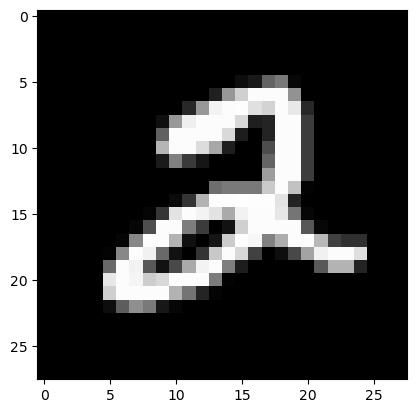

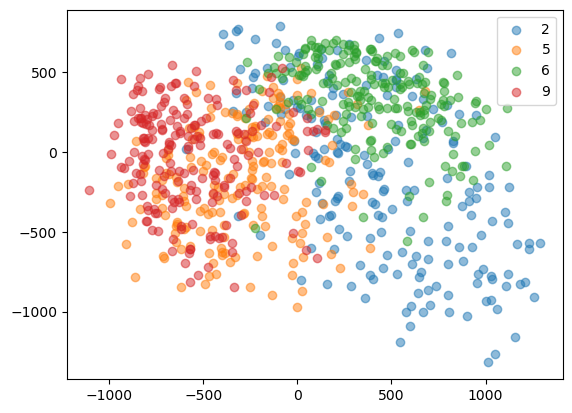

In [23]:
classes = [2,5,6,9]

X,y = load_mnist_data(classes, sample_size=200, dset='train', shuffle = False, data_path = data_path)
X = X.T

_,n_feats = X.shape

plt.figure()
plt.imshow(X[0,:].reshape(28,28),cmap = 'gray')

n_pcs = 5
models = [[1,1,1,1,1,n_feats-n_pcs],
        [1,1,1,2,n_feats-n_pcs],[1,1,2,1,n_feats-n_pcs],[1,2,1,1,n_feats-n_pcs],[2,1,1,1,n_feats-n_pcs],
        [3,1,1,n_feats-n_pcs],[2,2,1,n_feats-n_pcs],[1,3,1,n_feats-n_pcs],[2,1,2,n_feats-n_pcs],[1,2,2,n_feats-n_pcs],[1,1,3,n_feats-n_pcs],
        [4,1,n_feats-n_pcs],[3,2,n_feats-n_pcs],[2,3,n_feats-n_pcs],[1,4,n_feats-n_pcs],
        [5,n_feats-n_pcs]]

#regular PCA
eigval, eigvec = evd(X)
baseline_weights = eigvec[:,:n_pcs]
true_fl_type, _ = model_selection_eval(X, eigval, models, criterion="bic")
fl_type = list(np.cumsum(true_fl_type)[:-1])


mu = np.mean(X, axis=0)
X_centered = X - mu
pcs = X_centered @ baseline_weights

plt.figure()
for c in classes:
    plt.scatter(pcs[np.where(y == c),0],pcs[np.where(y == c),4], alpha = .5, label = c)

plt.legend()

fl_type0 = [0]+fl_type
for n_nbrs in [3,6,9,12,15,18]:
    for i in range(len(fl_type0)-1):

        print(fl_type0[i+1])
        # Step 2: Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(pcs[:,fl_type0[i]:fl_type0[i+1]], y, test_size=0.3, random_state=42)

        # Step 3: Initialize kNN classifier and fit it to the training data
        knn = KNeighborsClassifier(n_neighbors=n_nbrs)  # You can adjust k (n_neighbors) here
        knn.fit(X_train, y_train)

        # Step 4: Make predictions on the test set
        y_pred = knn.predict(X_test)

        # Step 5: Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy * 100:.2f}%")
    print('------------')



print('------------')
print('------------')
print('------------')

print('What if we try FlagRep???')
print('')

Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FlagRep(pcs, Aset)

fl_type0 = [0]+fl_type
for n_nbrs in [3,6,9,12,15,18]:
    for i in range(len(fl_type0)-1):

        print(fl_type0[i+1])
        # Step 2: Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(frep[:,fl_type0[i]:fl_type0[i+1]], y, test_size=0.3, random_state=42)

        # Step 3: Initialize kNN classifier and fit it to the training data
        knn = KNeighborsClassifier(n_neighbors=n_nbrs)  # You can adjust k (n_neighbors) here
        knn.fit(X_train, y_train)

        # Step 4: Make predictions on the test set
        y_pred = knn.predict(X_test)

        # Step 5: Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy * 100:.2f}%")
    print('------------')